In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc

In [68]:
elecciones = pd.read_csv('data/g9_data.csv')
elecciones.reset_index(drop=True)

/Users/msaied/mambaforge/envs/default/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,año,eleccion_tipo,eleccion_id,recuento_tipo,recuento_id,padron_tipo,distrito_id,distrito_nombre,seccionprovincial_id,seccionprovincial_nombre,...,mesa_tipo,mesa_electores,cargo_id,cargo_nombre,agrupacion_id,agrupacion_nombre,lista_numero,lista_nombre,votos_tipo,votos_cantidad
0,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,7.0,Sección Séptima,...,NATIVOS,346,1,PRESIDENTE Y VICE,134,UNION POR LA PATRIA,NaN,NaN,POSITIVO,98
1,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,7.0,Sección Séptima,...,NATIVOS,346,1,PRESIDENTE Y VICE,132,JUNTOS POR EL CAMBIO,NaN,NaN,POSITIVO,71
2,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,7.0,Sección Séptima,...,NATIVOS,346,1,PRESIDENTE Y VICE,135,LA LIBERTAD AVANZA,NaN,NaN,POSITIVO,71
3,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,7.0,Sección Séptima,...,NATIVOS,346,1,PRESIDENTE Y VICE,133,HACEMOS POR NUESTRO PAIS,NaN,NaN,POSITIVO,13
4,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,7.0,Sección Séptima,...,NATIVOS,346,1,PRESIDENTE Y VICE,136,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,NaN,NaN,POSITIVO,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330054,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,NATIVOS,93,9,PARLAMENTO MERCOSUR REGIONAL,0,NaN,NaN,NaN,EN BLANCO,13
330055,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,NATIVOS,93,9,PARLAMENTO MERCOSUR REGIONAL,0,NaN,NaN,NaN,NULO,0
330056,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,NATIVOS,93,9,PARLAMENTO MERCOSUR REGIONAL,0,NaN,NaN,NaN,IMPUGNADO,0
330057,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,NATIVOS,93,9,PARLAMENTO MERCOSUR REGIONAL,0,NaN,NaN,NaN,RECURRIDO,0


## Casos Anomalos

Para la detecciones de mesas anomalas, vamos a utilizar distintos criterios que podrian identificar anomalias para luego asignarles un score a cada una. A partir de estos scores, vamos a categorizar ciertas mesas como anomalas.

Mesas Inconsistentes:
- Mas votos que electores

Mesas Cerradas:
- Mesas con 0 votos

Criterios para la deteccion de casos anomalos:
- Mesas que tengan diferente cantidad de votos para los diferentes cargos.
- Mesas con altos porcentajes de votos no positivos.
- Comparación entre cargos: Compara los resultados de diferentes cargos (presidente, diputados y senadores) en la misma elección.
- Comparacion con resultados del mismo circuito electoral.
- Asistencia inusualmente alta o baja en comparacion al circuito electoral.

Con datasets externos:
- Comparacion con PASO
- Comparacion con elecciones anteriores

In [131]:
# Mesas incosistentes. Con mas votos que electores
# Vamos a eliminarlas del dataset

# Agrupamos por mesa y cargo y luego sumamos los votos
elecciones['asistencia_mesa'] = elecciones.groupby(['seccion_nombre', 'mesa_id', 'cargo_nombre'])['votos_cantidad'].transform('sum')

# Eliminamos las mesas que tienen mas votos que electores
df_incosistente = elecciones[elecciones['asistencia_mesa'] > elecciones['mesa_electores']]
df_incosistente.to_csv('criterios/mesas_incosistentes.csv', index=False)

In [133]:
# Mesas con 0 votantes
df_mesas_cerradas = elecciones[elecciones['asistencia_mesa'] == 0]
elecciones = elecciones[elecciones['asistencia_mesa'] > 0]

df_mesas_cerradas.to_csv('criterios/mesas_cerradas.csv', index=False)

In [ ]:
# Mesas que tengan diferente cantidad de votos para los diferentes cargos

# Agrupar el DataFrame por 'seccion_nombre' y 'mesa_id', y sumar los votos por cargo
mesas_con_sumas_distintas = elecciones.groupby(['seccion_nombre', 'mesa_id', 'cargo_nombre'])['votos_cantidad'].sum().reset_index()

# Calcular la cantidad única de sumas de votos dentro de cada grupo (es decir, mesas donde la suma de votos por cargo es distinta)
mesas_con_sumas_distintas = mesas_con_sumas_distintas.groupby(['seccion_nombre', 'mesa_id'])['votos_cantidad'].nunique().reset_index()

# Filtrar las mesas donde haya más de una suma de votos distinta para diferentes cargos
mesas_con_sumas_distintas = mesas_con_sumas_distintas[mesas_con_sumas_distintas['votos_cantidad'] > 1]


# Filtrar el DataFrame original por indice para quedarnos solo con las mesas que cumplen con el criterio
df_incosistente = elecciones.set_index(['seccion_nombre', 'mesa_id']).loc[mesas_con_sumas_distintas.set_index(['seccion_nombre', 'mesa_id']).index].reset_index()
df_incosistente.to_csv('criterios/mesas_totales_diferentes.csv', index=False)

In [134]:
# Mesas con alto porcentaje de voto no positivos

# Filtrar las filas que representan votos en blanco (ajusta según tu dataset)
tipos_a_verificar = [('EN BLANCO', 20), ('NULO', 10), ('IMPUGNADO', 10), ('RECURRIDO', 10)]

mesas_con_altos_porcentajes = pd.DataFrame(columns=elecciones.columns)
for tipo, umbral in tipos_a_verificar:
    votos = elecciones[elecciones['votos_tipo'] == tipo].copy()
    # Calcular el porcentaje de votos en blanco por mesa
    votos['porcentaje'] = (votos['votos_cantidad'] / votos['mesa_electores']) * 100

    # Establecer un umbral para un "alto" porcentaje de votos en blanco (ajusta según tus criterios)
    umbral_porcentaje_alto = umbral  # Por ejemplo, consideraremos "alto" si el porcentaje de votos en blanco es mayor al 10%

    # Filtrar mesas con cargo de presidente, diputado o senador nacional
    votos = votos[votos['cargo_nombre'].isin(['PRESIDENTE Y VICE', 'DIPUTADO NACIONAL', 'SENADOR NACIONAL'])]

    # Filtrar las mesas con alto porcentaje de votos en blanco
    mesas_con_alto = votos[votos['porcentaje'] > umbral_porcentaje_alto]

    # Mostrar las mesas con alto porcentaje de votos en blanco
    mesas_con_alto[['seccion_nombre', 'mesa_id', 'cargo_nombre', 'porcentaje']].sort_values(by='porcentaje', ascending=False)
    mesas_con_altos_porcentajes = pd.concat([mesas_con_alto, mesas_con_altos_porcentajes])

mesas_con_altos_porcentajes.drop_duplicates(inplace=True)
mesas_con_altos_porcentajes.to_csv('criterios/mesas_votos_no_positivos.csv', index=False)
mesas_con_altos_porcentajes.head(10)


,año,eleccion_tipo,eleccion_id,recuento_tipo,recuento_id,padron_tipo,distrito_id,distrito_nombre,seccionprovincial_id,seccionprovincial_nombre,...,cargo_id,cargo_nombre,agrupacion_id,agrupacion_nombre,lista_numero,lista_nombre,votos_tipo,votos_cantidad,asistencia_mesa,porcentaje
6547,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,1,PRESIDENTE Y VICE,0,NaN,NaN,NaN,IMPUGNADO,60,335,17.142857
49782,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,2,SENADOR NACIONAL,0,NaN,NaN,NaN,IMPUGNADO,60,335,17.142857
89283,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,3,DIPUTADO NACIONAL,0,NaN,NaN,NaN,IMPUGNADO,60,335,17.142857
46937,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,2,SENADOR NACIONAL,0,NaN,NaN,NaN,NULO,40,301,11.363636
67637,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,7.0,Sección Séptima,...,2,SENADOR NACIONAL,0,NaN,NaN,NaN,NULO,39,287,11.174785
69743,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,2,SENADOR NACIONAL,0,NaN,NaN,NaN,NULO,37,275,10.571429
76151,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,2,SENADOR NACIONAL,0,NaN,NaN,NaN,NULO,39,284,11.142857
76754,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,2,SENADOR NACIONAL,0,NaN,NaN,NaN,NULO,40,282,11.461318
77276,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,2,SENADOR NACIONAL,0,NaN,NaN,NaN,NULO,39,279,11.142857
77807,2023,GENERAL,2,PROVISORIO,1,NORMAL,2,Buenos Aires,2.0,Sección Segunda,...,2,SENADOR NACIONAL,0,NaN,NaN,NaN,NULO,20,141,10.362694


In [135]:
# Mesas con una asistencia anormalmente baja o alta
# Calcular la asistencia de la mesa como la suma de 'votos_cantidad' por agrupación y cargo
df_asistencia = elecciones.copy()

df_asistencia['asistencia_mesa'] = df_asistencia.groupby(['circuito_id', 'mesa_id', 'cargo_nombre'])['votos_cantidad'].transform('sum')

df_asistencia['votos_positivos'] = df_asistencia[df_asistencia['votos_tipo'] == 'POSITIVO'].groupby(['circuito_id', 'mesa_id', 'cargo_nombre'])['votos_cantidad'].transform('sum')


df_asistencia['asistencia_mesa'] = (df_asistencia['asistencia_mesa'] / df_asistencia['mesa_electores']) * 100

# Filtramos mesas con 0 de asistencia
df_asistencia = df_asistencia[df_asistencia['asistencia_mesa'] > 0]

# Filtramos mesas sin votos positivos
df_asistencia = df_asistencia[df_asistencia['votos_positivos'] > 0]

# Filtramos mesas de extranjeros
df_asistencia = df_asistencia[df_asistencia['mesa_tipo'] != 'EXTRANJEROS']

# Calcular el promedio de asistencia circuito
promedio_asistencia_circuito = df_asistencia.groupby('circuito_id')['asistencia_mesa'].mean().reset_index()
promedio_asistencia_circuito = promedio_asistencia_circuito.rename(columns={'asistencia_mesa': 'promedio_asistencia_circuito'})

# Combinar el DataFrame original con el promedio de asistencia circuito
df_asistencia = df_asistencia.merge(promedio_asistencia_circuito, on='circuito_id')

# Calcular la diferencia entre la asistencia de cada mesa y el promedio circuito
df_asistencia['diferencia_asistencia'] = df_asistencia['asistencia_mesa'] - df_asistencia['promedio_asistencia_circuito']

# Calcular el z-score de la diferencia de asistencia de cada mesa
df_asistencia['z_score_diferencia_asistencia'] = (df_asistencia['diferencia_asistencia'] - df_asistencia['diferencia_asistencia'].mean()) / df_asistencia['diferencia_asistencia'].std()

# Muestro las mesas con z-score absoluto mayor a 3 ordenado por z-score absoluto descendente
df_asistencia = df_asistencia[df_asistencia['z_score_diferencia_asistencia'].abs() > 3]
df_asistencia.sort_values(by='z_score_diferencia_asistencia', ascending=False).to_csv('criterios/mesas_anomalas_asistencia.csv', index=False)

In [136]:
# Mesas con diferencias contra el resultado del circuito

df = elecciones.copy()

# Moveremos los valores de votos_tipo para votos no positivos a agrupacion_nombre para agrupar de manera eficiente
df['agrupacion_nombre'] = df.apply(lambda x: x['agrupacion_nombre'] if x['votos_tipo'] == 'POSITIVO' else x['votos_tipo'], axis=1)

# Sumamos votos por circuito, agrupacion y cargo
votos_por_circuito = df.groupby(['circuito_id','agrupacion_nombre', 'cargo_nombre'])['votos_cantidad'].sum()

# Sumamos votos por circuito
total_por_circuito = votos_por_circuito.groupby('circuito_id').transform('sum')

# Calculamos el porcentaje de votos por circuito
porcentaje_por_circuito = (votos_por_circuito / total_por_circuito) * 100

# Crea un nuevo DataFrame con los porcentajes
porcentajes_por_circuito = porcentaje_por_circuito.reset_index(name='porcentaje')

# Convertir el dataframe a un diccionario
porcentajes_por_circuito = porcentajes_por_circuito.set_index(['circuito_id', 'agrupacion_nombre','cargo_nombre']).to_dict()['porcentaje']

# Calculemos porcentajes por mesa
df_comparacion = df.copy()

df_comparacion['porcentaje'] = df['votos_cantidad'] / df['mesa_electores'] * 100
df_comparacion['resultado_circuito'] = df_comparacion.apply(lambda x: porcentajes_por_circuito[(x['circuito_id'], x['agrupacion_nombre'], x['cargo_nombre'])], axis=1)

# Filtramos solo votos positivos
df_comparacion = df_comparacion[df_comparacion['votos_tipo'] == 'POSITIVO']
# Filtramos mesas de extranjeros
df_comparacion = df_comparacion[df_comparacion['mesa_tipo'] != 'EXTRANJEROS']

# Calculemos la diferencia absoluta de los porcentajes de la mesa tomando como referencia los del circuito
df_comparacion['diff'] = df_comparacion['porcentaje'] - df_comparacion['resultado_circuito']

df_comparacion['diff'] = df_comparacion['diff'].abs()
df_comparacion.sort_values(by='diff', ascending=False)

# Calucular el z-score de la diferencia de porcentajes de cada mesa
df_comparacion['z_score_diff'] = (df_comparacion['diff'] - df_comparacion['diff'].mean()) / df_comparacion['diff'].std()

# Mostramos las mesas con z-score absoluto mayor a 3 ordenado por z-score absoluto descendente
df_comparacion[df_comparacion['votos_tipo'] == 'POSITIVO'].sort_values(by='z_score_diff', ascending=False)

# Mesas con z score mayor a 3
df_comparacion = df_comparacion[df_comparacion['z_score_diff'].abs() > 3]
df_comparacion.to_csv('criterios/mesas_anomalas_porcentaje.csv', index=False)

### Comparar resultados entre cargos
Otro metodo para detectar anomalias sera comparar los resultados de distintos cargos dentro de la misma mesa

In [137]:
# Moveremos los valores de votos_tipo para votos no positivos a agrupacion_nombre para agrupar de manera eficiente
elecciones = pd.read_csv('data/g9_data.csv')

# Nos quedamos solo con presidente y vice, diputados y senadores
cargos = ['PRESIDENTE Y VICE', 'DIPUTADO NACIONAL', 'SENADOR NACIONAL']
elecciones = elecciones[elecciones.cargo_nombre.isin(cargos)]
elecciones['agrupacion_nombre'] = elecciones.apply(lambda x: x['agrupacion_nombre'] if x['votos_tipo'] == 'POSITIVO' else x['votos_tipo'], axis=1)

# Agrupar el DataFrame por 'seccion_nombre' y 'mesa_id', y sumar los votos por cargo
sumas_votos = elecciones.groupby(['circuito_id', 'mesa_id', 'cargo_nombre'])['votos_cantidad'].sum().reset_index()

# Pivotear los datos para tener las sumas de votos de presidente y diputados en columnas separadas
pivot_table = sumas_votos.pivot(index=['circuito_id', 'mesa_id'], columns='cargo_nombre', values='votos_cantidad').reset_index()



# Calcular la diferencia absoluta entre las sumas de votos de presidente y diputados
pivot_table['diferencia_presidente_senadores'] = abs(pivot_table['PRESIDENTE Y VICE'] - pivot_table['SENADOR NACIONAL'])
pivot_table['diferencia_presidente_diputados'] = abs(pivot_table['PRESIDENTE Y VICE'] - pivot_table['DIPUTADO NACIONAL'])
pivot_table['diferencia_diputados_senadores'] = abs(pivot_table['DIPUTADO NACIONAL'] - pivot_table['SENADOR NACIONAL'])

# Calculamos el z-score de la diferencia de votos entre presidente y diputados
pivot_table['z_diferencia_presidente_senadores'] = (pivot_table['diferencia_presidente_senadores'] - pivot_table['diferencia_presidente_senadores'].mean()) / pivot_table['diferencia_presidente_senadores'].std()
pivot_table['z_diferencia_presidente_diputados'] = (pivot_table['diferencia_presidente_diputados'] - pivot_table['diferencia_presidente_diputados'].mean()) / pivot_table['diferencia_presidente_diputados'].std()
pivot_table['z_diferencia_diputados_senadores'] = (pivot_table['diferencia_diputados_senadores'] - pivot_table['diferencia_diputados_senadores'].mean()) / pivot_table['diferencia_diputados_senadores'].std()

# Filtrar las mesas que tengan algun z-score mayor a 3
pivot_table = pivot_table[(pivot_table['z_diferencia_presidente_senadores'].abs() > 3) | (pivot_table['z_diferencia_presidente_diputados'].abs() > 3) | (pivot_table['z_diferencia_diputados_senadores'].abs() > 3)]

# Filtrar DataFrame original por indice para quedarnos solo con las mesas que cumplen con el criterio
df_mesas_anomalas = elecciones.set_index(['circuito_id', 'mesa_id']).loc[pivot_table.set_index(['circuito_id', 'mesa_id']).index].reset_index()

df_mesas_anomalas.to_csv('criterios/mesas_anomalas_intercargo.csv', index=False)


/Users/msaied/mambaforge/envs/default/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


/Users/msaied/mambaforge/envs/default/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Text(0.5, 1.0, 'Cantidad de mesas por tipo de anomalia')

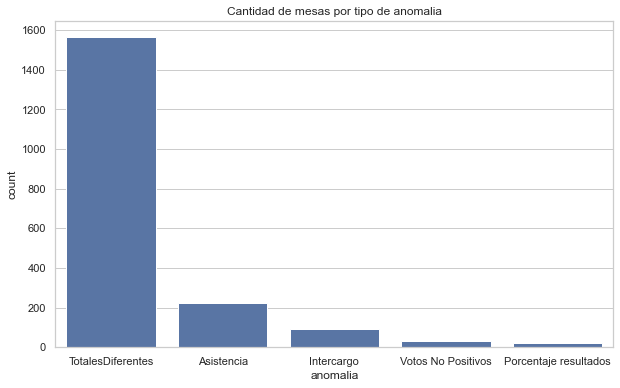

In [205]:
# Vamos a graficar la cantidad de mesas por tipo de anomalia
# Hacemos unique por circuito y mesa para que no se repitan

df_mesas_anomalas_intercargo = pd.read_csv('criterios/mesas_anomalas_intercargo.csv')
df_mesas_anomalas_intercargo = df_mesas_anomalas_intercargo.drop_duplicates(subset=['circuito_id', 'mesa_id'])
df_mesas_anomalas_intercargo['anomalia'] = 'Intercargo'

df_mesas_anomalas_asistencia = pd.read_csv('criterios/mesas_anomalas_asistencia.csv')
df_mesas_anomalas_asistencia = df_mesas_anomalas_asistencia.drop_duplicates(subset=['circuito_id', 'mesa_id'])
df_mesas_anomalas_asistencia['anomalia'] = 'Asistencia'

df_mesas_anomalas_porcentaje = pd.read_csv('criterios/mesas_anomalas_porcentaje.csv')
df_mesas_anomalas_porcentaje = df_mesas_anomalas_porcentaje.drop_duplicates(subset=['circuito_id', 'mesa_id'])
df_mesas_anomalas_porcentaje['anomalia'] = 'Porcentaje resultados'

df_mesas_anomalas_votos_no_positivos = pd.read_csv('criterios/mesas_votos_no_positivos.csv')
df_mesas_anomalas_votos_no_positivos = df_mesas_anomalas_votos_no_positivos.drop_duplicates(subset=['circuito_id', 'mesa_id'])
df_mesas_anomalas_votos_no_positivos['anomalia'] = 'Votos No Positivos'

df_mesas_totales_diferentes = pd.read_csv('criterios/mesas_totales_diferentes.csv')
df_mesas_totales_diferentes = df_mesas_totales_diferentes.drop_duplicates(subset=['circuito_id', 'mesa_id'])
df_mesas_totales_diferentes['anomalia'] = 'TotalesDiferentes'

df_graficos = pd.concat([df_mesas_anomalas_intercargo, df_mesas_anomalas_asistencia, df_mesas_anomalas_porcentaje, df_mesas_anomalas_votos_no_positivos, df_mesas_totales_diferentes])
df_graficos_bajos = pd.concat([df_mesas_anomalas_intercargo, df_mesas_anomalas_asistencia, df_mesas_anomalas_porcentaje, df_mesas_anomalas_votos_no_positivos])


# Graficamos frecuencia de anomalias
plt.figure(figsize=(10, 6))

ax = sns.countplot(x="anomalia", data=df_graficos, order=df_graficos['anomalia'].value_counts().index)
ax.set_title('Cantidad de mesas por tipo de anomalia')


## Fuentes complementarias

Proponemos las siguientes fuentes complementarias que podriamos implementar como criterios extra a la hora de detectar anomalias:
- Resultados elecciones PASO: Utilizando los resultados de las elecciones PASO, unificando listas y proyectando votos de partidos afines, podemos detectar anormalidades en las mesas.
- Resultados elecciones pasadas: Utilizando datos de las elecciones pasadas, como por ejemplo 2015 y 2019, podemos ver tendencias en las mesas.

In [57]:
# g9_paso_data = pd.read_csv('data/2023_PASO/ResultadosElectorales.csv')

# df_g9_paso = g9_paso_data[g9_paso_data['distrito_nombre'] == 'Buenos Aires']
# del g9_paso_data
# gc.collect()
# df_g9_paso = df_g9_paso[(df_g9_paso['seccionprovincial_nombre'].isin(['Sección Segunda', 'Sección Capital', 'Sección Séptima']))]

# df_g9_paso.to_csv('data/g9_data_paso.csv', index=False)

df_g9_paso = pd.read_csv('data/g9_data_paso.csv')

In [58]:
# Vamos a comparar los resultados de las PASO, sumando el total de cada partido, con los resultados de las generales. Para cada mesa
# Vamos a hacer esto solo para presidente, senadores y diputados nacionales

igualdades = {
    'DIPUTADOS/AS NACIONALES': 'DIPUTADO NACIONAL',
    'SENADORES/AS NACIONALES': 'SENADOR NACIONAL',
    'PRESIDENTE/A': 'PRESIDENTE Y VICE'
}

df_g9_generales = elecciones[elecciones['cargo_nombre'].isin(['PRESIDENTE Y VICE', 'DIPUTADO NACIONAL', 'SENADOR NACIONAL'])]
df_g9_paso = df_g9_paso[df_g9_paso['cargo_nombre'].isin(['PRESIDENTE/A', 'DIPUTADOS/AS NACIONALES', 'SENADORES/AS NACIONALES'])]

df_g9_paso['cargo_nombre'] = df_g9_paso['cargo_nombre'].apply(lambda x: igualdades[x])

# Agrupar resultados por mesa y partido en el primer DataFrame
votos_generales = df_g9_generales.groupby(['circuito_id','mesa_id', 'agrupacion_nombre', 'cargo_nombre'])['votos_cantidad'].sum().reset_index()

# Agrupar resultados por mesa y partido en el segundo DataFrame
votos_paso = df_g9_paso.groupby(['circuito_id', 'mesa_id', 'agrupacion_nombre', 'cargo_nombre'])['votos_cantidad'].sum().reset_index()

# Unir los DataFrames por la columna de la mesa (que debe tener el mismo nombre en ambos DataFrames)
mesas_combinadas = pd.merge(votos_generales, votos_paso, on=['circuito_id', 'mesa_id', 'agrupacion_nombre', 'cargo_nombre'], suffixes=('_generales', '_paso'))

# Calcular la diferencia absoluta de votos entre los mismos partidos en las mismas mesas
mesas_combinadas['diferencia_absoluta'] = abs(mesas_combinadas['votos_cantidad_generales'] - mesas_combinadas['votos_cantidad_paso'])

mesas_combinadas.sort_values(by='diferencia_absoluta', ascending=False)

# Calcular el z-score de la diferencia de votos entre los mismos partidos en las mismas mesas

mesas_combinadas['z_score_diferencia'] = (mesas_combinadas['diferencia_absoluta'] - mesas_combinadas['diferencia_absoluta'].mean()) / mesas_combinadas['diferencia_absoluta'].std()

# Filtrar las mesas donde el z-score sea mayor a 3
mesas_combinadas = mesas_combinadas[mesas_combinadas['z_score_diferencia'].abs() > 3]
mesas_combinadas.to_csv('criterios/mesas_anomalas_paso.csv', index=False)

Ademas de usar las PASO podemos usar elecciones pasadas para ver tendencias en las distintas mesas

In [59]:
# df_2019 = pd.read_csv('data/2019_Generales/ResultadosElectorales.csv')

# df_2019 = df_2019[df_2019['distrito_nombre'] == 'BUENOS AIRES']
# df_2019 = df_2019[df_2019['seccionprovincial_nombre'].isin(['Segunda Sección', 'Capital Sección', 'Séptima Sección'])]

# df_2019.to_csv('data/g9_data_2019.csv', index=False)

df_2019 = pd.read_csv('data/g9_data_2019.csv')

/Users/msaied/mambaforge/envs/default/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [60]:
# Vamos a hacer esto solo para presidente por una cuestion de facilidad, pero el analisis podria facilmente extenderse a otros cargos
# A este metodo tambien se le podrian agregar otras elecciones y ver el comportamiento de los votos en las mesas a lo largo del tiempo.
# Por razones de tiempo y poder de computo no lo haremos en este caso.

igualdades = {
    'PRESIDENTE': 'PRESIDENTE Y VICE'
}

# Vamos a limitar el analisis a Union por la Patria y Juntos por el Cambio, dado que LLA no participo en estas elecciones
agrupaciones = {
    'FRENTE DE TODOS': 'UNION POR LA PATRIA',
    'JUNTOS POR EL CAMBIO': 'JUNTOS POR EL CAMBIO',
}

df_g9_generales = elecciones[elecciones['cargo_nombre'].isin(['PRESIDENTE Y VICE'])]
df_g9_2019 = df_2019[df_2019['cargo_nombre'].isin(['PRESIDENTE'])]

df_g9_2019['cargo_nombre'] = df_g9_2019['cargo_nombre'].apply(lambda x: igualdades[x])

df_g9_2019 = df_g9_2019[df_g9_2019['agrupacion_nombre'].isin(['FRENTE DE TODOS','JUNTOS POR EL CAMBIO'])]
df_g9_generales = df_g9_generales[df_g9_generales['agrupacion_nombre'].isin(['UNION POR LA PATRIA','JUNTOS POR EL CAMBIO'])]

df_g9_2019['agrupacion_nombre'] = df_g9_2019['agrupacion_nombre'].apply(lambda x: agrupaciones[x])
df_g9_2019["circuito_id"] = df_g9_2019["circuito_id"].apply(lambda x: x.lstrip("0"))
df_g9_generales["circuito_id"] = df_g9_generales["circuito_id"].apply(lambda x: x.lstrip("0"))

# Agrupar resultados por mesa y partido en el primer DataFrame
votos_generales = df_g9_generales.groupby(['circuito_id','mesa_id', 'agrupacion_nombre', 'cargo_nombre'])['votos_cantidad'].sum().reset_index()

# Agrupar resultados por mesa y partido
votos_2019 = df_g9_2019.groupby(['circuito_id', 'mesa_id', 'agrupacion_nombre', 'cargo_nombre'])['votos_cantidad'].sum().reset_index()

# Unir los DataFrames por la columna de la mesa (que debe tener el mismo nombre en ambos DataFrames)
mesas_combinadas_2019 = pd.merge(votos_generales, votos_2019, on=['circuito_id', 'mesa_id', 'agrupacion_nombre', 'cargo_nombre'], suffixes=('_generales', '_2019'))

# Calcular la diferencia absoluta de votos entre los mismos partidos en las mismas mesas
mesas_combinadas_2019['diferencia_absoluta'] = abs(mesas_combinadas_2019['votos_cantidad_generales'] - mesas_combinadas_2019['votos_cantidad_2019'])

mesas_combinadas_2019.sort_values(by='diferencia_absoluta', ascending=False)

# Calcular el z-score de la diferencia de votos entre los mismos partidos en las mismas mesas

mesas_combinadas_2019['z_score_diferencia'] = (mesas_combinadas_2019['diferencia_absoluta'] - mesas_combinadas_2019['diferencia_absoluta'].mean()) / mesas_combinadas_2019['diferencia_absoluta'].std()

# Filtrar las mesas donde el z-score sea mayor a 3
mesas_combinadas_2019 = mesas_combinadas_2019[mesas_combinadas_2019['z_score_diferencia'].abs() > 3]

mesas_combinadas_2019.to_csv('criterios/mesas_anomalas_2019.csv', index=False)

<ipython-input-60-4b04c4284ed0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_g9_2019['cargo_nombre'] = df_g9_2019['cargo_nombre'].apply(lambda x: igualdades[x])


## Deteccion de Anomalias

A partir de todos los metodos descriptos anteriormente, vamos a generar un Anomaly Score, asignando a cada criterio un numero y poniendo un umbral minimo de Score para ser categorizado como anomalo. Por cada criterio que cumpla una mesa 

In [61]:
# Generamos un Anomaly Score para cada mesa, basado en si es anómala en alguno de los criterios anteriores
# Mesas cerradas con 0 votantes son categorizadas como anómalas
# Mesas incosistenter con la cantidad de electores son categorizadas como anómalas

# Mesas con alto porcentaje de voto no positivos
mesas_votos_no_positivos = pd.read_csv('criterios/mesas_votos_no_positivos.csv')

# Mesas con una asistencia anormalmente baja o alta
mesas_anomalas_asistencia = pd.read_csv('criterios/mesas_anomalas_asistencia.csv')

# Mesas con diferencias contra el resultado del circuito
mesas_anomalas_porcentaje = pd.read_csv('criterios/mesas_anomalas_porcentaje.csv')

# Mesas con diferencias entre votos intercargo
mesas_anomalas_intercargo = pd.read_csv('criterios/mesas_anomalas_intercargo.csv')

# Mesas con votos totales diferentes
mesas_totales_diferentes = pd.read_csv('criterios/mesas_totales_diferentes.csv')

# Mesas con diferencias PASO
mesas_anomalas_paso = pd.read_csv('criterios/mesas_anomalas_paso.csv')

# Mesas con diferencias 2019
mesas_anomalas_2019 = pd.read_csv('criterios/mesas_anomalas_2019.csv')


# A cada criterio le asignamos un peso
mesas_votos_no_positivos['anomaly_score'] = 0.4
mesas_votos_no_positivos['anomalia'] = 'votos_no_positivos_anomalo'

mesas_anomalas_asistencia['anomaly_score'] = 0.2
mesas_anomalas_asistencia['anomalia'] = 'asistencia_anomala'

mesas_anomalas_porcentaje['anomaly_score'] = 0.3
mesas_anomalas_porcentaje['anomalia'] = 'resultado_anomalo'

mesas_anomalas_intercargo['anomaly_score'] = 0.5
mesas_anomalas_intercargo['anomalia'] = 'intercargo_anomalo'

mesas_totales_diferentes['anomaly_score'] = 0.2
mesas_totales_diferentes['anomalia'] = 'totales_diferentes'

mesas_anomalas_paso['anomaly_score'] = 0.1
mesas_anomalas_paso['anomalia'] = 'paso_anomalo'

mesas_anomalas_2019['anomaly_score'] = 0.1
mesas_anomalas_2019['anomalia'] = '2019_anomalo'

# Generamos DataFrame con cantidad de mesas por error por Seccion Provincial
mesas_votos_no_positivos = mesas_votos_no_positivos.groupby(['seccion_nombre', 'anomalia'])['anomaly_score'].count().reset_index()


# Concatenamos todos los DataFrames
df_anomaly_score = pd.concat([
    mesas_votos_no_positivos[['circuito_id', 'mesa_id', 'anomaly_score', 'anomalia']],
    mesas_anomalas_asistencia[['circuito_id', 'mesa_id', 'anomaly_score', 'anomalia']],
    mesas_anomalas_porcentaje[['circuito_id', 'mesa_id', 'anomaly_score', 'anomalia']],
    mesas_anomalas_intercargo[['circuito_id', 'mesa_id', 'anomaly_score', 'anomalia']],
    mesas_totales_diferentes[['circuito_id', 'mesa_id', 'anomaly_score', 'anomalia']],
    mesas_anomalas_paso[['circuito_id', 'mesa_id', 'anomaly_score', 'anomalia']],
mesas_anomalas_2019[['circuito_id', 'mesa_id', 'anomaly_score', 'anomalia']]
])


df_anomaly_score = df_anomaly_score.drop_duplicates(subset=['circuito_id', 'mesa_id', 'anomalia'])

df_anomaly_score_sum = df_anomaly_score.groupby(['circuito_id', 'mesa_id'])['anomaly_score'].sum().reset_index()

# Filtrar las filas donde la suma de 'anomaly_score' sea mayor o igual a 0.5
df_anomaly_score_sum = df_anomaly_score_sum[df_anomaly_score_sum['anomaly_score'] >= 0.5]

# Concatenar los textos de las anomalías encontradas para cada mesa
anomalias_por_mesa = df_anomaly_score[df_anomaly_score[['circuito_id', 'mesa_id']].apply(tuple, axis=1).isin(df_anomaly_score_sum[['circuito_id', 'mesa_id']].apply(tuple, axis=1))]
anomalias_concatenadas = anomalias_por_mesa.groupby(['circuito_id', 'mesa_id'])['anomalia'].apply(', '.join).reset_index()

# Unir las anomalías concatenadas con el DataFrame original por mesa
df_final = df_anomaly_score_sum.merge(anomalias_concatenadas, on=['circuito_id', 'mesa_id'], how='left')
df_final.to_csv('resultados/mesas_anomalas.csv', index=False)

/Users/msaied/mambaforge/envs/default/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Resultados

En el archivo `resultados/mesas_anomalas.csv` vemos un pequeño desglose de las mesas clasificadas como anomalas y los criterios por los cuales fue clasificada de esa manera.

<AxesSubplot:title={'center':'Distribución del Anomaly Score'}, xlabel='Anomaly Score', ylabel='Frecuencia'>

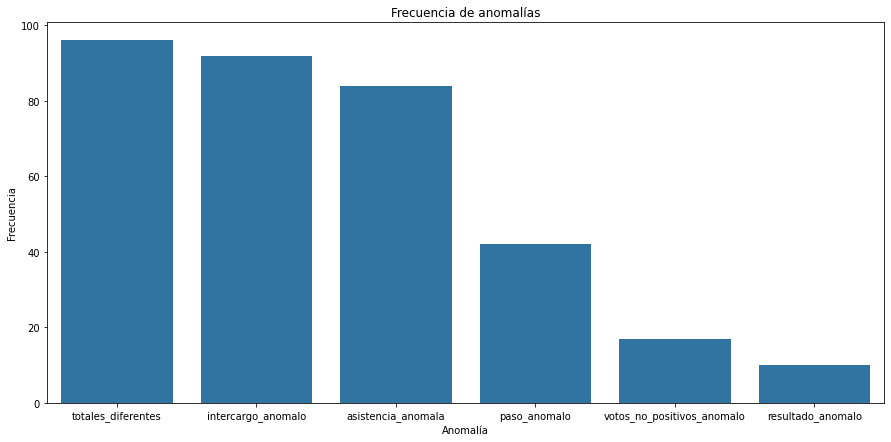

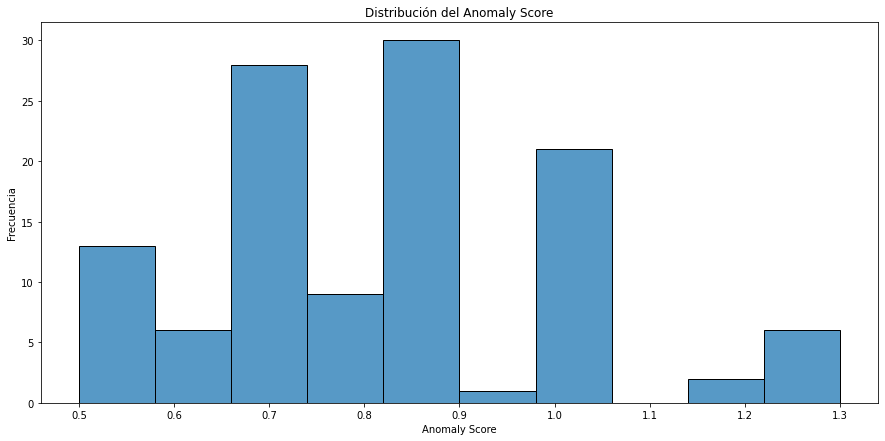

In [65]:

df = pd.read_csv('resultados/mesas_anomalas.csv')

# Separa las anomalías por comas y crea una lista de todas las anomalías
anomalias_lista = df['anomalia'].str.split(', ').explode().tolist()

# Cuenta la frecuencia de cada anomalía
frecuencia_anomalias = pd.Series(anomalias_lista).value_counts().reset_index()
frecuencia_anomalias.columns = ['Anomalia', 'Frecuencia']

# Graficar la frecuencia de anomalías
plt.figure(figsize=(15, 7))

# Agregar titulo
plt.title('Frecuencia de anomalías')

# Agregar etiquetas a los ejes
plt.xlabel('Anomalía')
plt.ylabel('Frecuencia')

# Graficar el gráfico de barras
sns.barplot(x='Anomalia', y='Frecuencia', data=frecuencia_anomalias)

# Graficar la distribucion del anomaly score
plt.figure(figsize=(15, 7))

# Agregar titulo
plt.title('Distribución del Anomaly Score')

# Agregar etiquetas a los ejes
plt.xlabel('Anomaly Score')
plt.ylabel('Frecuencia')

# Graficar el histograma
sns.histplot(df['anomaly_score'], bins=10)

In [89]:
# Generamos DataFrame con metricas sobre los errores en las mesas
errores_df = pd.DataFrame(columns=["seccionprovincial_nombre", "error", 'cantidad_mesas', '%'])

# Función para contar mesas por error y agregar los resultados al DataFrame "errores_df"
def contar_mesas_por_error(dataframe, error, seccionprovincial_nombre):
    circuitos = list(elecciones[elecciones['seccionprovincial_nombre'] == seccionprovincial_nombre]['circuito_id'])
    circuitos = [str(circuito).lstrip('0') for circuito in circuitos]
    dataframe['circuito_id'] = dataframe['circuito_id'].apply(lambda x: str(x).lstrip('0'))
    dataframe_seccion = dataframe[dataframe['circuito_id'].isin(circuitos)] 

    cantidad_mesas_totales = len(elecciones[elecciones['seccionprovincial_nombre'] == seccionprovincial_nombre].groupby(['circuito_id','mesa_id']).size().reset_index())

    cantidad_mesas = len(dataframe_seccion.groupby(['circuito_id','mesa_id']).size().reset_index())
    porcentaje_mesas = cantidad_mesas / cantidad_mesas_totales * 100
    errores_df.loc[len(errores_df)] = [seccionprovincial_nombre, error, cantidad_mesas, porcentaje_mesas]

# Supongamos que tienes una lista de errores llamada 'lista_de_errores' que contiene los nombres de los errores
lista_de_errores = [
    (mesas_votos_no_positivos, 'Votos no positivos muy altos'),
    (mesas_anomalas_asistencia, 'Asistencia anormalmente baja/alta'), 
    (mesas_anomalas_porcentaje, 'Porcentaje de votos vs circuito anormalmente alto/bajo'),
    (mesas_anomalas_intercargo, 'Diferencia de votos entre cargos anormalmente alta'),
    (mesas_totales_diferentes, 'Cantidad de votos totales por cargo por mesa diferentes'),
    (mesas_anomalas_paso, 'Diferencia de votos entre PASO y Generales'),
    (mesas_anomalas_2019, 'Diferencia de votos entre 2019 y Generales')                    
]  # Reemplaza con los nombres reales de los errores

# Realizar el conteo de mesas por cada tipo de error
for seccion_provincial in elecciones['seccionprovincial_nombre'].unique():
    for dataframe, error in lista_de_errores:
        contar_mesas_por_error(dataframe, error, seccion_provincial)

# Mostrar el DataFrame "errores_df" con los recuentos de mesas, error y sección provincial
errores_df.to_csv('resultados/errores_por_seccionprovincial.csv', index=False)
errores_df.head(10)

,seccionprovincial_nombre,error,cantidad_mesas,%
0,Sección Séptima,Votos no positivos muy altos,7,0.815851
1,Sección Séptima,Asistencia anormalmente baja/alta,47,5.477855
2,Sección Séptima,Porcentaje de votos vs circuito anormalmente a...,3,0.349650
3,Sección Séptima,Diferencia de votos entre cargos anormalmente ...,16,1.864802
4,Sección Séptima,Cantidad de votos totales por cargo por mesa d...,264,30.769231
5,Sección Séptima,Diferencia de votos entre PASO y Generales,34,3.962704
6,Sección Séptima,Diferencia de votos entre 2019 y Generales,5,0.582751
7,Sección Segunda,Votos no positivos muy altos,23,1.050228
8,Sección Segunda,Asistencia anormalmente baja/alta,116,5.296804
9,Sección Segunda,Porcentaje de votos vs circuito anormalmente a...,15,0.684932


Vemos que la anomalia mas comun es la que indica que una mesa tuvo una gran diferencia en los resultados para los distintos cargos. Luego tambien tenemos casi con la misma cantidad, el criterio que indica que una mesa tiene totales distintos, esperable dado que un tercio de todas las mesas tienen aunque sea pequeñas discrepancias entre los votos totales para los diferentes cargos. La asistencia anomala tambien es muy comun y ya luego en menor medida votos no positivis y resultados distintos con respecto al circuito.

Cabe destacar, que en el archivo `criterios/mesas_totales_diferentes.csv` podemos ver una gran cantidad de mesas donde la suma de los votos es distinta para los distintos cargos. Para el correcto analisis de las anomalias decidimos incluirlas en el score pero dada su frecuencia en un tercio de las mesas, le bajamos lo que sumaba en el score final pero aun asi, creemos que es algo bastante importante por si solo para revisar ya que estas diferencias tan extendidas deberian ser revisadas por si mismas.